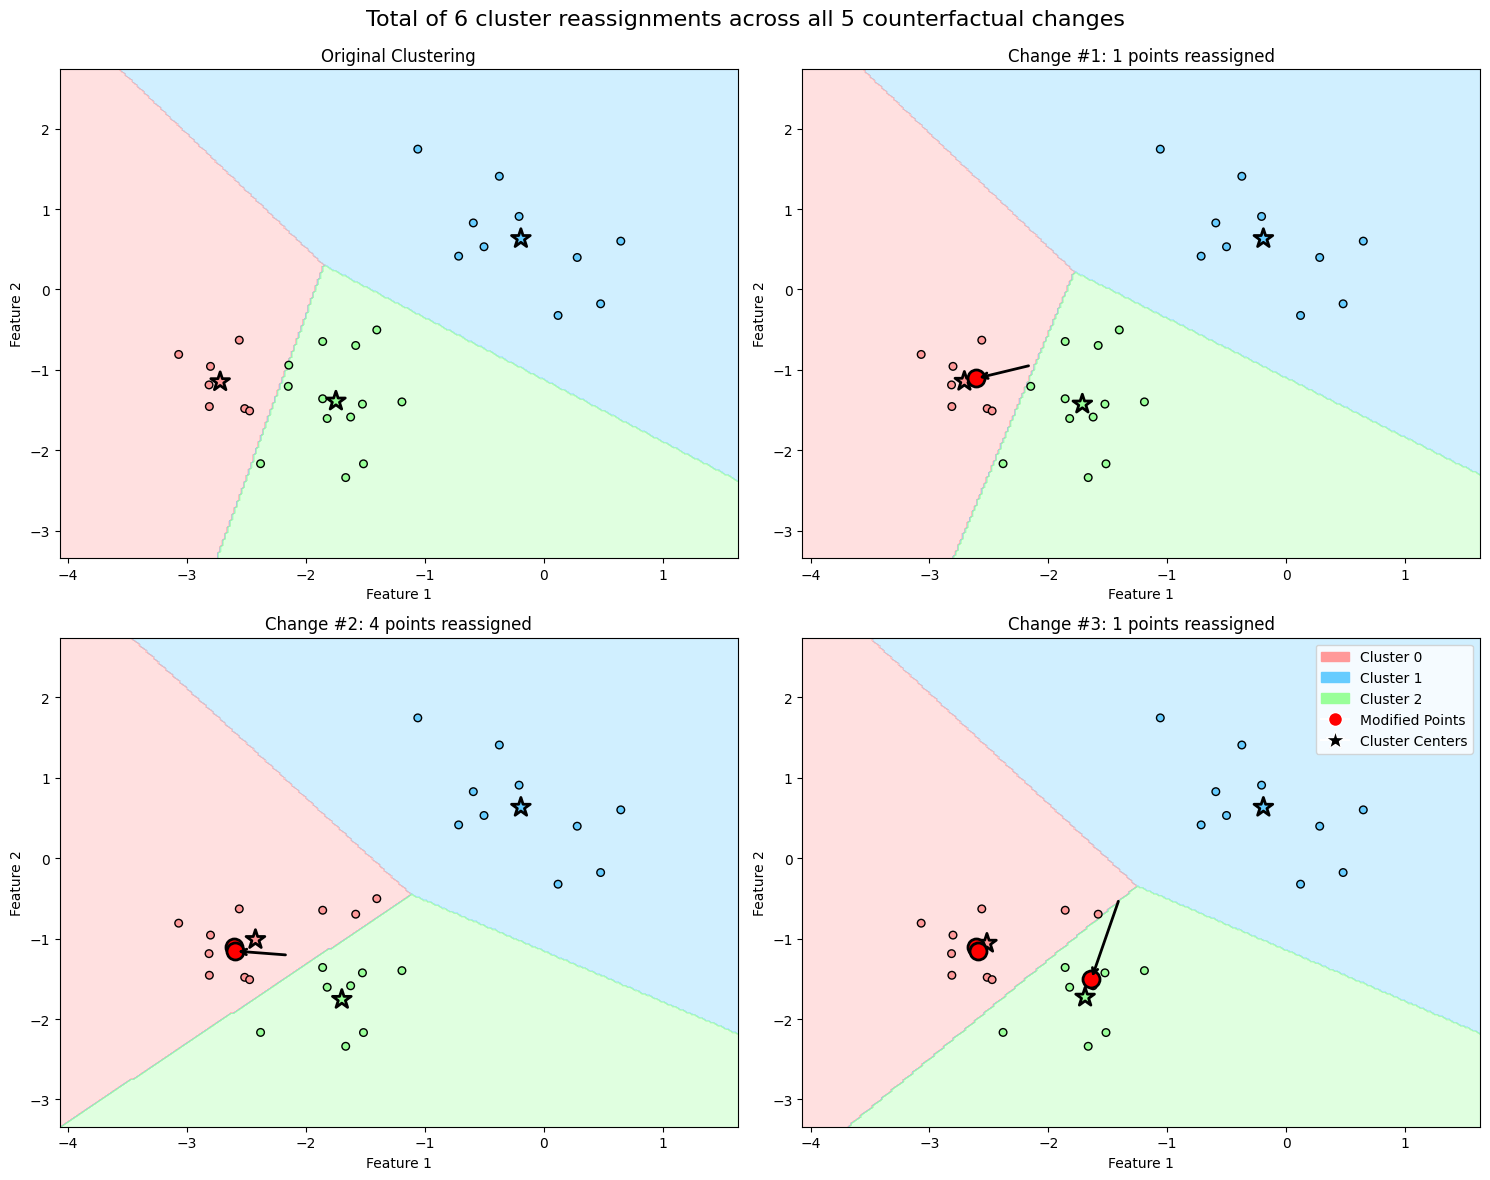

Change #1:
  Original cluster: 2
  Target cluster: 0
  Points that changed clusters: 1

Change #2:
  Original cluster: 2
  Target cluster: 0
  Points that changed clusters: 4

Change #3:
  Original cluster: 0
  Target cluster: 2
  Points that changed clusters: 1



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
state = 1

np.random.seed(state)

# Generate synthetic data with 3 clusters that are closer together
X, y = make_blobs(n_samples=30, centers=3, cluster_std=1.0, center_box=(-4, 4), random_state=state)
X = X * 0.6  # Scale down the data to bring clusters closer

# Initialize figure
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(2, 2, figure=fig)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
       fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# Create colormap
cmap = ListedColormap(['#FF9999', '#66CCFF', '#99FF99'])

# Create a meshgrid to visualize decision boundaries
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Function to find boundary points
def find_boundary_point(X, kmeans, exclude_indices=None):
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # Calculate distances to closest centers
    distances_to_centers = np.sqrt(((X[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
    closest_center_distances = np.min(distances_to_centers, axis=1)
    second_closest_indices = np.argsort(distances_to_centers, axis=1)[:, 1]
    second_closest_distances = np.take_along_axis(distances_to_centers, second_closest_indices[:, np.newaxis], axis=1).flatten()
    
    # Calculate boundary scores (smaller difference means closer to boundary)
    boundary_scores = second_closest_distances - closest_center_distances
    
    # Sort points by boundary score (excluding already moved points)
    if exclude_indices is not None:
        boundary_scores[exclude_indices] = np.inf
    
    # Get top boundary point
    candidate_idx = np.argmin(boundary_scores)
    return candidate_idx

# Initialize tracking of moved points
moved_indices = []
current_X = X.copy()
current_kmeans = None
points_info = []

# Plot original data
current_kmeans = KMeans(n_clusters=3, random_state=state)
current_kmeans.fit(current_X)
Z = current_kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

axs[0].contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
axs[0].scatter(current_X[:, 0], current_X[:, 1], c=current_kmeans.labels_, s=30, cmap=cmap, edgecolor='k')
axs[0].scatter(current_kmeans.cluster_centers_[:, 0], current_kmeans.cluster_centers_[:, 1], 
              marker='*', s=200, c=[0, 1, 2], cmap=cmap, edgecolor='k', linewidth=2)
axs[0].set_title('Original Clustering')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')

# Perform 5 counterfactual changes
for i in range(3):
    # Find a point near a decision boundary
    point_idx = find_boundary_point(current_X, current_kmeans, moved_indices)
    moved_indices.append(point_idx)
    
    original_point = current_X[point_idx].copy()
    original_cluster = current_kmeans.predict([original_point])[0]
    
    # Find closest different cluster center
    centers = current_kmeans.cluster_centers_
    dist_to_centers = np.sqrt(((original_point - centers) ** 2).sum(axis=1))
    closest_centers = np.argsort(dist_to_centers)
    target_cluster = closest_centers[1]  # Second closest center
    
    # Create counterfactual by moving point toward target cluster
    counterfactual_point = original_point + 0.8 * (centers[target_cluster] - original_point)
    
    # Update the dataset
    current_X[point_idx] = counterfactual_point
    
    # Re-fit KMeans on updated dataset
    new_kmeans = KMeans(n_clusters=3, random_state=state)
    new_kmeans.fit(current_X)
    
    # Count points that changed clusters
    points_changed = np.sum(current_kmeans.labels_ != new_kmeans.labels_)
    
    # Store point information
    points_info.append({
        'original_point': original_point,
        'counterfactual_point': counterfactual_point,
        'original_cluster': original_cluster,
        'target_cluster': target_cluster,
        'points_changed': points_changed
    })
    
    # Update current state
    current_kmeans = new_kmeans
    
    # Visualize the current state
    Z = current_kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Plot in the corresponding subplot
    ax = axs[i+1]
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    ax.scatter(current_X[:, 0], current_X[:, 1], c=current_kmeans.labels_, s=30, cmap=cmap, edgecolor='k')
    ax.scatter(current_kmeans.cluster_centers_[:, 0], current_kmeans.cluster_centers_[:, 1], 
              marker='*', s=200, c=[0, 1, 2], cmap=cmap, edgecolor='k', linewidth=2)
    
    # Mark all moved points
    for j in range(i+1):
        moved_point = points_info[j]['counterfactual_point']
        ax.scatter(moved_point[0], moved_point[1], s=150, 
                  c='red', marker='o', edgecolor='k', linewidth=2)
    
    # Add an arrow showing the most recent point movement
    arrow_props = dict(arrowstyle='->', linewidth=2, color='black')
    ax.annotate('', xy=(counterfactual_point[0], counterfactual_point[1]), 
                xytext=(original_point[0], original_point[1]), arrowprops=arrow_props)
    
    # Add title with information
    ax.set_title(f'Change #{i+1}: {points_changed} points reassigned')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Add legend to the last plot
legend_elements = [
    mpatches.Patch(color='#FF9999', label='Cluster 0'),
    mpatches.Patch(color='#66CCFF', label='Cluster 1'),
    mpatches.Patch(color='#99FF99', label='Cluster 2'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', 
               markersize=10, label='Modified Points'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='k', 
               markersize=15, label='Cluster Centers')
]
axs[3].legend(handles=legend_elements, loc='upper right')

# Add a summary of all changes
total_points_changed = sum(info['points_changed'] for info in points_info)
summary_text = f"Total of {total_points_changed} cluster reassignments across all 3 counterfactual changes"
fig.suptitle(summary_text, fontsize=16, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Print detailed information about each change
for i, info in enumerate(points_info):
    print(f"Change #{i+1}:")
    print(f"  Original cluster: {info['original_cluster']}")
    print(f"  Target cluster: {info['target_cluster']}")
    print(f"  Points that changed clusters: {info['points_changed']}")
    print()